<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Описание-данных" data-toc-modified-id="Описание-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Описание данных</a></span></li><li><span><a href="#Загрузка-данных" data-toc-modified-id="Загрузка-данных-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Загрузка данных</a></span></li><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Исследование-данных" data-toc-modified-id="Исследование-данных-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Исследование данных</a></span></li><li><span><a href="#Обучение-моделей" data-toc-modified-id="Обучение-моделей-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Обучение моделей</a></span><ul class="toc-item"><li><span><a href="#CatBoostClassifier" data-toc-modified-id="CatBoostClassifier-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>CatBoostClassifier</a></span></li><li><span><a href="#LightGBM" data-toc-modified-id="LightGBM-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>LightGBM</a></span></li></ul></li><li><span><a href="#Тестирование-модели" data-toc-modified-id="Тестирование-модели-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Тестирование модели</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Вывод</a></span></li></ul></div>

# ТЕЛЕКОМ

# Постановка задачи

Подготовить прототип модели машинного обучения для оператора связи «Ниединогоразрыва.ком». Модель должна предсказать, планирует ли пользователь уйти. Оператор предоставляет два основных типа услуг: 

1. Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.
2. Интернет. Подключение может быть двух типов: через телефонную линию (DSL*,* от англ. *digital subscriber line*, «цифровая абонентская линия») или оптоволоконный кабель (*Fiber optic*). 

За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта и возможность получения электронного чека.

В нашем распоряжении данные, которые состоят из 4 файлов, полученных из разных источников:

- `contract.csv` — информация о договоре;
- `personal.csv` — персональные данные клиента;
- `internet.csv` — информация об интернет-услугах;
- `phone.csv` — информация об услугах телефонии.

Во всех файлах столбец `customerID` содержит код клиента.

Информация о договорах актуальна на 1 февраля 2020.



В данном пректе нам предстоит решить задачу бинарной классификации останется клиент в компании или нет, эффективность модели будем оценивать метрикой AUC-ROC

План работ:

 - Подготовить данные:
   - загрузить и изучить данные, объединить таблицы по `customerID`. Проверить данные на пропуски, дубликаты. Заполнить пропущенные значения, если это возможно.
 - Провести исследовательский анализ данных:
      - изучить как распределены данные, проверить на мультиколлинеарность,
      - определить обучающие признаки, по `EndDate` сформировать целевой признак.
      - разделить данные на обучающую и тестовую выборку в соотношении 75/25. Обучающую выборку проверить на выбросы и баланс классов.
 
 - Построить и обучить модели CatBoost и логистической регрессии. Подобрать гиперпараметры. Выбрать модель с наибольшей предсказательной силой, оценивая метрикой AUC-ROC.
 - Провести финальное тестирование.
  

## Описание данных


Файл `contract.csv` содержит следующую информацию о договоре:

 -  customerID   - идентификатор клиента
 -  BeginDate    - дата заключения договора 
 -  EndDate      - дата расторжения договора 
 -  Type         - тип договора (месячный, годовой)
 -  PaperlessBilling  - факт выставления счета на электронную почту 
 -  PaymentMethod     - способ оплаты 
 -  MonthlyCharges    - ежемесячные траты на услуги
 -  TotalCharges      - всего потрачено денег на услуги 

Файл `personal.csv` персональные данные клиента:

  - customerID   - идентификатор клиента
  - gender - пол
  - SeniorCitizen - наличие песнионногостатуса по возрасту
  - Partner - наличия супруга(и)
  - Dependents - наличие иждевенцев

Файл `internet.csv` информация об интернет-услугах:

  -  customerID   - идентификатор клиента
  -  InternetService - способ подключения к интернету может быть двух типов: через телефонную линию (DSL, «цифровая абонентская линия») или оптоволоконный кабель (Fiber optic)
  -  OnlineSecurity   - блокировка небезопасных сайтов
  -  OnlineBackup     - облачное хранилище файлов для резервного копирования данных
  -  DeviceProtection - антивирус
  -  TechSupport      - выделенная линия технической поддержки 
  -  StreamingTV      - стриминговое телевидение 
  -  StreamingMovies  - каталог фильмов 

Файл `phone.csv` информация об услугах телефонии:

  -  customerID   - идентификатор клиента
  -  MultipleLines - наличие возможности ведения параллельных линий во время звонка

## Загрузка данных

In [1]:
! pip install phik
!pip install imbalanced-learn

In [2]:
# импорт библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import matplotlib.style as style
from matplotlib import pyplot
import phik

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import matplotlib.style as style
from matplotlib import pyplot
from matplotlib.ticker import ScalarFormatter

In [3]:
# загрузка данных
try:
    contract = pd.read_csv('C:/Users/LENOVO/Downloads/final_provider (1)/final_provider/contract.csv', index_col='customerID')
    personal = pd.read_csv('C:/Users/LENOVO/Downloads/final_provider (1)/final_provider/personal.csv', index_col='customerID')
    internet = pd.read_csv('C:/Users/LENOVO/Downloads/final_provider (1)/final_provider/internet.csv', index_col='customerID')
    phone = pd.read_csv('C:/Users/LENOVO/Downloads/final_provider (1)/final_provider/phone.csv', index_col='customerID')
except:
    contract = pd.read_csv('/datasets/final_provider/contract.csv', index_col='customerID')
    personal = pd.read_csv('/datasets/final_provider/personal.csv', index_col='customerID')
    internet = pd.read_csv('/datasets/final_provider/internet.csv', index_col='customerID')
    phone = pd.read_csv('/datasets/final_provider/phone.csv', index_col='customerID')

In [4]:
display(contract.head())
contract.info()
contract.describe(include='all')

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
customerID,,,,,,,
7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   BeginDate         7043 non-null   object 
 1   EndDate           7043 non-null   object 
 2   Type              7043 non-null   object 
 3   PaperlessBilling  7043 non-null   object 
 4   PaymentMethod     7043 non-null   object 
 5   MonthlyCharges    7043 non-null   float64
 6   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(6)
memory usage: 440.2+ KB


,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
count,7043,7043,7043,7043,7043,7043.000000,7043
unique,77,5,3,2,4,NaN,6531
top,2014-02-01,No,Month-to-month,Yes,Electronic check,NaN,20.2
freq,366,5174,3875,4171,2365,NaN,11
mean,NaN,NaN,NaN,NaN,NaN,64.761692,NaN
std,NaN,NaN,NaN,NaN,NaN,30.090047,NaN
min,NaN,NaN,NaN,NaN,NaN,18.250000,NaN
25%,NaN,NaN,NaN,NaN,NaN,35.500000,NaN
50%,NaN,NaN,NaN,NaN,NaN,70.350000,NaN
75%,NaN,NaN,NaN,NaN,NaN,89.850000,NaN


Файл contract.csv содержит таблицу расмером 8х7043, кроме столбца MonthlyCharges (тип float64) данные типа object

- customerID - идентификатор клиента, все значения 7043  уникальны,
- Type - тип договора, имеет 3 уникальных значения, чаще всего встречается Month-to-month,
- PaperlessBilling - факт выставления счета на электронную почту, принимает 2 уникальных значения.
- MonthlyCharges - ежемесячные траты на услуги - в среднем тратят клиенты 64,7, минимум 18,25, максимум 118,75,
- TotalCharges - всего потрачено денег на услуги - тип объект, есть пропущенные значения, которые необходимо заполнить,
- BeginDate - дата заключения договора и EndDate - дата расторжения договора имеют тип объект, так как рассматриваем задачу не в динамике можно удалить эти столбцы, после фрмирования целевого признака по EndDate.

In [5]:
display(personal.head())
personal.info()
personal.describe(include='all')

,gender,SeniorCitizen,Partner,Dependents
customerID,,,,
7590-VHVEG,Female,0,Yes,No
5575-GNVDE,Male,0,No,No
3668-QPYBK,Male,0,No,No
7795-CFOCW,Male,0,No,No
9237-HQITU,Female,0,No,No


<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   gender         7043 non-null   object
 1   SeniorCitizen  7043 non-null   int64 
 2   Partner        7043 non-null   object
 3   Dependents     7043 non-null   object
dtypes: int64(1), object(3)
memory usage: 275.1+ KB


,gender,SeniorCitizen,Partner,Dependents
count,7043,7043.000000,7043,7043
unique,2,NaN,2,2
top,Male,NaN,No,No
freq,3555,NaN,3641,4933
mean,NaN,0.162147,NaN,NaN
std,NaN,0.368612,NaN,NaN
min,NaN,0.000000,NaN,NaN
25%,NaN,0.000000,NaN,NaN
50%,NaN,0.000000,NaN,NaN
75%,NaN,0.000000,NaN,NaN


Файл personal.csv содержит таблицу расмером 5х7043:

- customerID - идентификатор клиента, все значения 7043  уникальны,
- SeniorCitizen - имеет числовой тип, остальные столбцы тип object, принимающие 2 уникальных значения - категориальные признаки.

In [6]:
display(internet.head())
internet.info()
internet.describe()

,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
customerID,,,,,,,
7590-VHVEG,DSL,No,Yes,No,No,No,No
5575-GNVDE,DSL,Yes,No,Yes,No,No,No
3668-QPYBK,DSL,Yes,Yes,No,No,No,No
7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
9237-HQITU,Fiber optic,No,No,No,No,No,No


<class 'pandas.core.frame.DataFrame'>
Index: 5517 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   InternetService   5517 non-null   object
 1   OnlineSecurity    5517 non-null   object
 2   OnlineBackup      5517 non-null   object
 3   DeviceProtection  5517 non-null   object
 4   TechSupport       5517 non-null   object
 5   StreamingTV       5517 non-null   object
 6   StreamingMovies   5517 non-null   object
dtypes: object(7)
memory usage: 344.8+ KB


,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
count,5517,5517,5517,5517,5517,5517,5517
unique,2,2,2,2,2,2,2
top,Fiber optic,No,No,No,No,No,No
freq,3096,3498,3088,3095,3473,2810,2785


Файл internet.csv содержит таблицу размером 8х5517, customerID все занчения уникальны, в этой таблице значений меньше не все клиенты пользуются интернет-услугами. Значения всех столбцов типа object, кроме customerID категориальные признаки.

In [7]:
display(phone.head())
phone.info()
phone.describe()

,MultipleLines
customerID,
5575-GNVDE,No
3668-QPYBK,No
9237-HQITU,No
9305-CDSKC,Yes
1452-KIOVK,Yes


<class 'pandas.core.frame.DataFrame'>
Index: 6361 entries, 5575-GNVDE to 3186-AJIEK
Data columns (total 1 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   MultipleLines  6361 non-null   object
dtypes: object(1)
memory usage: 99.4+ KB


,MultipleLines
count,6361
unique,2
top,No
freq,3390


Файл phone.csv содержит таблицу размером 2х6361, customerID все занчения уникальны,  MultipleLines типа object, принимающие два значения, категориальный признак.

 Нам предоставлены данные о 7043 клиентах компании, не все клиенты пользуются всем набором услуг. После загрузки и изучения данных определились с формированием целевого признака по EndDate (contract.csv) - дата расторжения договора, 0 - клиент остается, 1 - уходит. Так как расматриваем задачу не в динамике, после формирования целевого признака удалим столбцы  BeginDate - дата заключения договора и EndDate - дата расторжения договора.
 
 Есть пропущенные значения в столбце TotalCharges - всего потрачено денег на услуги, обработаем пропуски после объединения таблиц. 
 
 Так как CatBoost позволяет использовать категориальные признаки без необходимости их предварительной обработки, для этого достаточно задать категориальные признаки с помощью параметра cat_features, то кодировку признаков будем проводить только для модели линейной регрессии, после проверки на мультиколлинеарность.
 

## Подготовка данных

Объединим таблицы методом `join`, по умолчанию установлен тип слияния how='left'

In [8]:
data = contract.join([personal,internet, phone])
data.info()
display(data.describe(include='all'))
data.head()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   BeginDate         7043 non-null   object 
 1   EndDate           7043 non-null   object 
 2   Type              7043 non-null   object 
 3   PaperlessBilling  7043 non-null   object 
 4   PaymentMethod     7043 non-null   object 
 5   MonthlyCharges    7043 non-null   float64
 6   TotalCharges      7043 non-null   object 
 7   gender            7043 non-null   object 
 8   SeniorCitizen     7043 non-null   int64  
 9   Partner           7043 non-null   object 
 10  Dependents        7043 non-null   object 
 11  InternetService   5517 non-null   object 
 12  OnlineSecurity    5517 non-null   object 
 13  OnlineBackup      5517 non-null   object 
 14  DeviceProtection  5517 non-null   object 
 15  TechSupport       5517 non-null   object 
 16  StreamingTV       5517 non-null 

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
count,7043,7043,7043,7043,7043,7043.000000,7043,7043,7043.000000,7043,7043,5517,5517,5517,5517,5517,5517,5517,6361
unique,77,5,3,2,4,NaN,6531,2,NaN,2,2,2,2,2,2,2,2,2,2
top,2014-02-01,No,Month-to-month,Yes,Electronic check,NaN,20.2,Male,NaN,No,No,Fiber optic,No,No,No,No,No,No,No
freq,366,5174,3875,4171,2365,NaN,11,3555,NaN,3641,4933,3096,3498,3088,3095,3473,2810,2785,3390
mean,NaN,NaN,NaN,NaN,NaN,64.761692,NaN,NaN,0.162147,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,30.090047,NaN,NaN,0.368612,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,18.250000,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,35.500000,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,70.350000,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,89.850000,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
customerID,,,,,,,,,,,,,,,,,,,
7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,NaN
5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No
7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN
9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No


In [9]:
# выведем количество уникальные значения столбца EndDate
data['EndDate'].value_counts()

No                     5174
2019-11-01 00:00:00     485
2019-12-01 00:00:00     466
2020-01-01 00:00:00     460
2019-10-01 00:00:00     458
Name: EndDate, dtype: int64

Столбец 'TotalCharges' распознан как тип object. Это значит, что в столбце есть не числовые значения или пропуски, а они помешают нашим расчётам. Используем метод Pandas — to_numeric(). Он превращает значения столбца в числовой тип float64 (вещественное число). Зададим параметру 'errors' ='coerce' — некорректные значения принудительно заменяются на NaN.

In [10]:
data['TotalCharges'] = pd.to_numeric(data['TotalCharges'], errors='coerce')
data['TotalCharges'].isna().sum()

11

11 пропущенных значений bp 7043, строки можно удалить

In [11]:
# удалим пропущенные значения в TotalCharges
data = data.dropna(subset=['TotalCharges'])
data.shape

(7032, 19)

In [12]:
data.isna().sum()

BeginDate              0
EndDate                0
Type                   0
PaperlessBilling       0
PaymentMethod          0
MonthlyCharges         0
TotalCharges           0
gender                 0
SeniorCitizen          0
Partner                0
Dependents             0
InternetService     1520
OnlineSecurity      1520
OnlineBackup        1520
DeviceProtection    1520
TechSupport         1520
StreamingTV         1520
StreamingMovies     1520
MultipleLines        680
dtype: int64

In [13]:
# обнаружили дубликаты, но они возникли из-за того ,что Id клиента задали как индекс для объединения таблиц
data[data.duplicated()]

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
customerID,,,,,,,,,,,,,,,,,,,
8605-ITULD,2020-01-01,No,Month-to-month,No,Mailed check,19.55,19.55,Female,0,No,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
3247-MHJKM,2020-01-01,No,Month-to-month,No,Mailed check,20.20,20.20,Male,0,No,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
5996-DAOQL,2020-01-01,No,Month-to-month,Yes,Mailed check,20.45,20.45,Male,0,No,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
2668-TZSPS,2020-01-01,No,Month-to-month,No,Mailed check,20.45,20.45,Male,0,No,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
2636-ALXXZ,2019-12-01,2020-01-01 00:00:00,Month-to-month,Yes,Electronic check,69.60,69.60,Female,1,No,No,Fiber optic,No,No,No,No,No,No,No
7096-UCLNH,2020-01-01,No,Month-to-month,No,Mailed check,20.05,20.05,Male,0,No,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
8048-DSDFQ,2020-01-01,No,Month-to-month,No,Mailed check,20.20,20.20,Male,0,No,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
8749-CLJXC,2020-01-01,No,Month-to-month,No,Mailed check,20.05,20.05,Male,0,No,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
2676-ISHSF,2020-01-01,No,Month-to-month,No,Mailed check,20.30,20.30,Male,0,No,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No


Заполним пропуски в столбцах c категориальными значениями на 'not provided'

In [14]:
data = data.fillna('not provided')
print(data.isna().sum())
data.describe(include='all')

BeginDate           0
EndDate             0
Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
MultipleLines       0
dtype: int64


,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
count,7032,7032,7032,7032,7032,7032.000000,7032.000000,7032,7032.000000,7032,7032,7032,7032,7032,7032,7032,7032,7032,7032
unique,76,5,3,2,4,NaN,NaN,2,NaN,2,2,3,3,3,3,3,3,3,3
top,2014-02-01,No,Month-to-month,Yes,Electronic check,NaN,NaN,Male,NaN,No,No,Fiber optic,No,No,No,No,No,No,No
freq,366,5163,3875,4168,2365,NaN,NaN,3549,NaN,3639,4933,3096,3497,3087,3094,3472,2809,2781,3385
mean,NaN,NaN,NaN,NaN,NaN,64.798208,2283.300441,NaN,0.162400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,30.085974,2266.771362,NaN,0.368844,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,18.250000,18.800000,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,35.587500,401.450000,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,70.350000,1397.475000,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,89.862500,3794.737500,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Добавим целевой признак `client_class`  по столбцу EndDate со значением "0", если клиент действующий и "1" если расторгнул договор.

In [15]:
# добавим столбец client_class со значением "0", если клиент действующий и "1" если расторгнул договор
data.loc[data['EndDate'] == 'No', 'client_class'] = 0
data.loc[data['EndDate'] != 'No', 'client_class'] = 1
data['client_class'].value_counts()

0.0    5163
1.0    1869
Name: client_class, dtype: int64

В целевом признаке присутствует дисбаланс классов в соотношении 3:1, чуть больше четверти клиентов расторгнули договор.

In [16]:
data['BeginDate'].value_counts()

2014-02-01    366
2019-10-01    237
2019-09-01    237
2019-11-01    237
2020-01-01    233
             ... 
2016-11-01     50
2014-01-01      7
2013-12-01      3
2013-10-01      3
2013-11-01      2
Name: BeginDate, Length: 76, dtype: int64

In [17]:
#заменим значение "No"  в столбце EndDate на дату актуальности данных
data.loc[data['EndDate'] == 'No', 'EndDate'] = '2020-02-01'
data.query('EndDate == "No"')

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,client_class
customerID,,,,,,,,,,,,,,,,,,,,


In [18]:
data['EndDate'] = pd.to_datetime(data['EndDate'], format='%Y-%m-%d %H:%M:%S')
data['BeginDate'] = pd.to_datetime(data['BeginDate'], format='%Y-%m-%d %H:%M:%S')
#data['EndDate'] = pd.DatetimeIndex(data['EndDate']).day
#ata['BeginDate'] = pd.DatetimeIndex(data['BeginDate']).day
data['year'] = pd.DatetimeIndex(data['EndDate']).year - pd.DatetimeIndex(data['BeginDate']).year
data.info()
data['year'].value_counts()

<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   BeginDate         7032 non-null   datetime64[ns]
 1   EndDate           7032 non-null   datetime64[ns]
 2   Type              7032 non-null   object        
 3   PaperlessBilling  7032 non-null   object        
 4   PaymentMethod     7032 non-null   object        
 5   MonthlyCharges    7032 non-null   float64       
 6   TotalCharges      7032 non-null   float64       
 7   gender            7032 non-null   object        
 8   SeniorCitizen     7032 non-null   int64         
 9   Partner           7032 non-null   object        
 10  Dependents        7032 non-null   object        
 11  InternetService   7032 non-null   object        
 12  OnlineSecurity    7032 non-null   object        
 13  OnlineBackup      7032 non-null   object        
 14  DeviceProtecti

1    1474
6    1282
0     958
2     941
5     822
3     803
4     752
Name: year, dtype: int64

In [19]:
data['EndDate'].value_counts()

2020-02-01    5163
2019-11-01     485
2019-12-01     466
2020-01-01     460
2019-10-01     458
Name: EndDate, dtype: int64

In [20]:
# удалим столбцы BeginDate и EndDate
data = data.drop(['BeginDate', 'EndDate'], axis=1)
data.head()

,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,client_class,year
customerID,,,,,,,,,,,,,,,,,,,
7590-VHVEG,Month-to-month,Yes,Electronic check,29.85,29.85,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,not provided,0.0,0
5575-GNVDE,One year,No,Mailed check,56.95,1889.50,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No,0.0,3
3668-QPYBK,Month-to-month,Yes,Mailed check,53.85,108.15,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No,1.0,0
7795-CFOCW,One year,No,Bank transfer (automatic),42.30,1840.75,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,not provided,0.0,4
9237-HQITU,Month-to-month,Yes,Electronic check,70.70,151.65,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No,1.0,0


In [21]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Type              7032 non-null   object 
 1   PaperlessBilling  7032 non-null   object 
 2   PaymentMethod     7032 non-null   object 
 3   MonthlyCharges    7032 non-null   float64
 4   TotalCharges      7032 non-null   float64
 5   gender            7032 non-null   object 
 6   SeniorCitizen     7032 non-null   int64  
 7   Partner           7032 non-null   object 
 8   Dependents        7032 non-null   object 
 9   InternetService   7032 non-null   object 
 10  OnlineSecurity    7032 non-null   object 
 11  OnlineBackup      7032 non-null   object 
 12  DeviceProtection  7032 non-null   object 
 13  TechSupport       7032 non-null   object 
 14  StreamingTV       7032 non-null   object 
 15  StreamingMovies   7032 non-null   object 
 16  MultipleLines     7032 non-null 

## Исследование данных

Проверим данные на мультиколлинеарность, используя Phi_K  —  последовательно работает между категориальными, порядковыми и интервальными переменными. 

In [22]:
data.phik_matrix()

interval columns not set, guessing: ['MonthlyCharges', 'TotalCharges', 'SeniorCitizen', 'client_class', 'year']


,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,client_class,year
Type,1.000000,0.106151,0.277528,0.388557,0.507638,0.000000,0.085800,0.179294,0.146126,0.503776,0.636227,0.580887,0.630968,0.671126,0.548723,0.553780,0.244802,0.251283,0.625309
PaperlessBilling,0.106151,1.000000,0.368945,0.467547,0.205050,0.000000,0.241715,0.010489,0.170650,0.231145,0.208084,0.195065,0.195398,0.200363,0.204617,0.202005,0.100063,0.295194,0.037628
PaymentMethod,0.277528,0.368945,1.000000,0.398849,0.349956,0.000000,0.291989,0.244661,0.222859,0.323013,0.314888,0.292646,0.297187,0.316805,0.283902,0.284844,0.174953,0.448559,0.326008
MonthlyCharges,0.388557,0.467547,0.398849,1.000000,0.762904,0.005522,0.304546,0.204575,0.182283,0.919005,0.812548,0.818861,0.827363,0.816645,0.864821,0.863544,0.710293,0.359623,0.307829
TotalCharges,0.507638,0.205050,0.349956,0.762904,1.000000,0.000000,0.148024,0.424655,0.118247,0.507972,0.529657,0.568314,0.574911,0.537700,0.567778,0.569165,0.494060,0.280973,0.694107
gender,0.000000,0.000000,0.000000,0.005522,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
SeniorCitizen,0.085800,0.241715,0.291989,0.304546,0.148024,0.000000,1.000000,0.018075,0.323629,0.160452,0.127108,0.109855,0.110029,0.135073,0.111610,0.113611,0.087978,0.232897,0.017828
Partner,0.179294,0.010489,0.244661,0.204575,0.424655,0.000000,0.018075,1.000000,0.651635,0.000000,0.091140,0.091990,0.099685,0.076244,0.081850,0.077710,0.086495,0.232215,0.348693
Dependents,0.146126,0.170650,0.222859,0.182283,0.118247,0.000000,0.323629,0.651635,1.000000,0.107328,0.116236,0.096785,0.093606,0.108747,0.087232,0.083895,0.011135,0.252268,0.163493
InternetService,0.503776,0.231145,0.323013,0.919005,0.507972,0.000000,0.160452,0.000000,0.107328,1.000000,0.949461,0.942839,0.942811,0.948878,0.946750,0.946275,0.739821,0.195860,0.070427


In [23]:
data.phik_matrix().unstack().sort_values(ascending=False).drop_duplicates().head(35)

interval columns not set, guessing: ['MonthlyCharges', 'TotalCharges', 'SeniorCitizen', 'client_class', 'year']


Type              Type                1.000000
StreamingMovies   StreamingTV         0.965356
DeviceProtection  StreamingMovies     0.953754
                  StreamingTV         0.952815
TechSupport       OnlineSecurity      0.952637
DeviceProtection  TechSupport         0.950238
OnlineSecurity    InternetService     0.949461
InternetService   TechSupport         0.948878
OnlineBackup      TechSupport         0.947746
                  DeviceProtection    0.947480
                  OnlineSecurity      0.947213
OnlineSecurity    DeviceProtection    0.946776
StreamingTV       InternetService     0.946750
TechSupport       StreamingMovies     0.946471
                  StreamingTV         0.946386
InternetService   StreamingMovies     0.946275
OnlineBackup      StreamingTV         0.945784
StreamingMovies   OnlineBackup        0.945409
OnlineSecurity    StreamingMovies     0.943254
StreamingTV       OnlineSecurity      0.943078
InternetService   OnlineBackup        0.942839
DeviceProtect

Коэффициент корреляции client_group (срок пользования услугами) и  Type (тип договора) - 0,78, удалив один из признаков можно потерять из обучающего набора новых абонентов.

Интернет-услуги коррелируют с ежемесячными расходами MonthlyCharges, коэффициенты больше 0,8 и InternetService коэфициент больше 0,9.

Коэффициент корреляции между MonthlyCharges и TotalCharges - 0,76, MonthlyCharges и MultipleLines - 0,71, client_group и TotalCharges - 0,72

MonthlyCharges желательно оставить,  не будем оспользовать TotalCharges и InternetService  для обучения.

 Интернет-услуги сильно коррелируют с суммой ежемесячных оплат, достаточно оставить MonthlyCharges и удалить 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies'.
  По причине высокой корреляции также не будем использоввать в дальнейшем TotalCharges.

In [24]:
data_f = data.drop(['TotalCharges', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies'], axis=1)

In [25]:
data_f.phik_matrix().unstack().sort_values(ascending=False).drop_duplicates().head()

interval columns not set, guessing: ['MonthlyCharges', 'SeniorCitizen', 'client_class', 'year']


Type              Type              1.000000
MonthlyCharges    MultipleLines     0.710293
Dependents        Partner           0.651635
year              Type              0.625309
PaperlessBilling  MonthlyCharges    0.467547
dtype: float64

In [26]:
data['MonthlyCharges'].describe()

count    7032.000000
mean       64.798208
std        30.085974
min        18.250000
25%        35.587500
50%        70.350000
75%        89.862500
max       118.750000
Name: MonthlyCharges, dtype: float64

In [27]:
data['TotalCharges'].describe()

count    7032.000000
mean     2283.300441
std      2266.771362
min        18.800000
25%       401.450000
50%      1397.475000
75%      3794.737500
max      8684.800000
Name: TotalCharges, dtype: float64

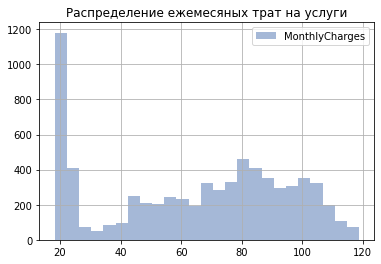

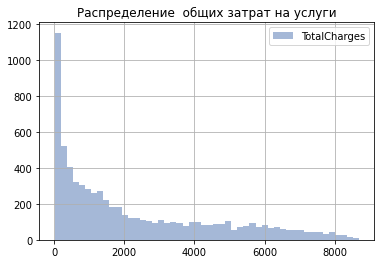

In [28]:
plt.style.use('seaborn-deep')

data['MonthlyCharges'].hist(bins=25, alpha=0.5, label='MonthlyCharges')
plt.title('Распределение ежемесяных трат на услуги')
plt.legend()
plt.show()
data['TotalCharges'].hist(bins=50, alpha=0.5, label='TotalCharges')
plt.title('Распределение  общих затрат на услуги')
plt.legend()
plt.show()


По гистограммам распределения MonthlyCharges заметен всплеск ежемесячных платежи в диапозоне от 18-25  и TotalCharges тоже есть значения близкие к нулю.

In [29]:
data.query('MonthlyCharges < 25').head()

,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,client_class,year
customerID,,,,,,,,,,,,,,,,,,,
7469-LKBCI,Two year,No,Credit card (automatic),18.95,326.80,Male,0,No,No,not provided,not provided,not provided,not provided,not provided,not provided,not provided,No,0.0,2
8191-XWSZG,One year,No,Mailed check,20.65,1022.95,Female,0,No,No,not provided,not provided,not provided,not provided,not provided,not provided,not provided,No,0.0,5
1680-VDCWW,One year,No,Bank transfer (automatic),19.80,202.25,Male,0,Yes,No,not provided,not provided,not provided,not provided,not provided,not provided,not provided,No,0.0,1
1066-JKSGK,Month-to-month,No,Mailed check,20.15,20.15,Male,0,No,No,not provided,not provided,not provided,not provided,not provided,not provided,not provided,No,1.0,0
7310-EGVHZ,Month-to-month,No,Bank transfer (automatic),20.20,20.20,Male,0,No,No,not provided,not provided,not provided,not provided,not provided,not provided,not provided,No,0.0,0


In [30]:
data_filter = (
    data
    .pivot_table(index='client_class', values='MonthlyCharges', aggfunc='mean') # сводная таблица по платформам и суммарным продажам
    .sort_values(by='client_class', ascending=False) # отсортировали по возрастанию
)
data_filter.head()


,MonthlyCharges
client_class,
1.0,74.441332
0.0,61.307408


In [31]:
data_filter = (
    data
    .pivot_table(index='client_class', values='TotalCharges', aggfunc='mean') # сводная таблица по платформам и суммарным продажам
    .sort_values(by='client_class', ascending=False) # отсортировали по возрастанию
)
data_filter.head()


,TotalCharges
client_class,
1.0,1531.796094
0.0,2555.344141


По сводной таблице ежемесячных платежей, видим , что с более высоким средним чеком пользователи расторгают договор.

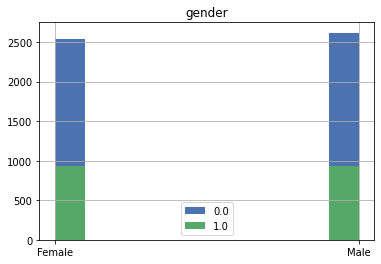

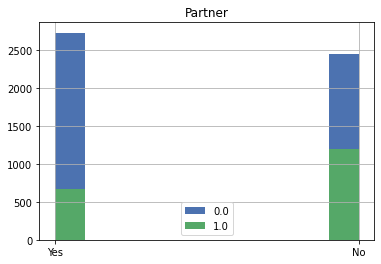

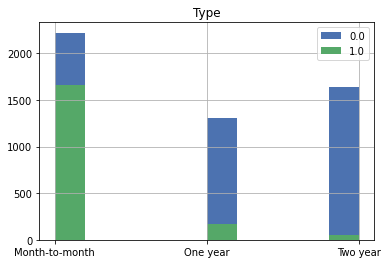

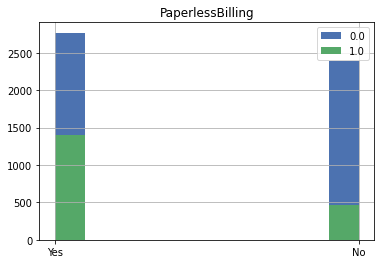

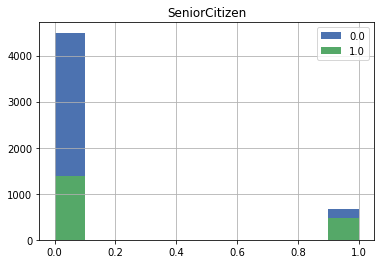

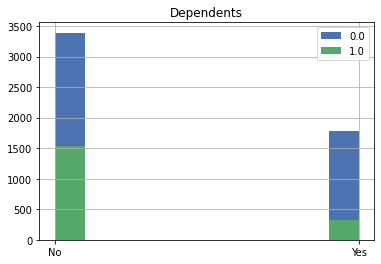

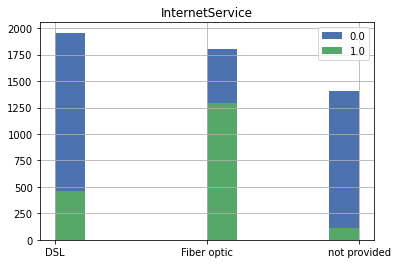

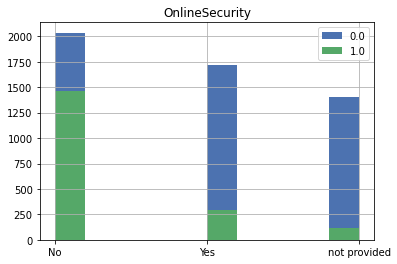

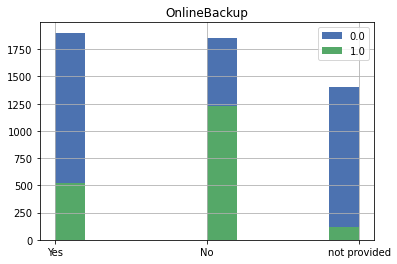

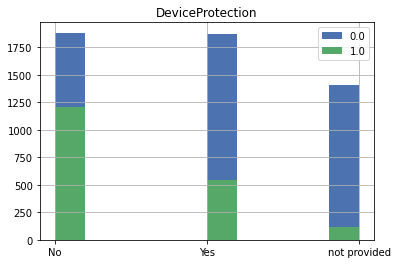

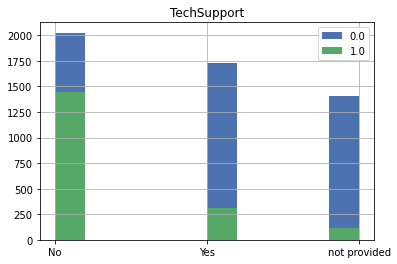

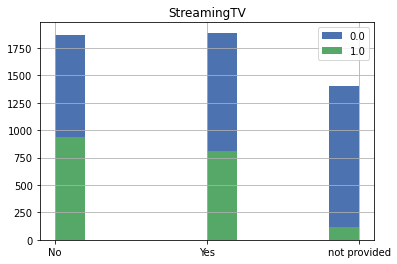

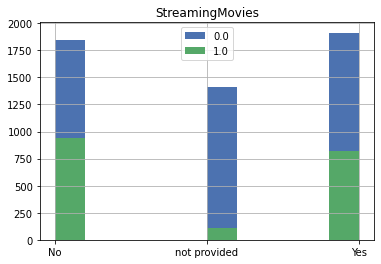

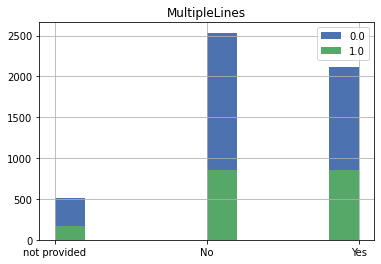

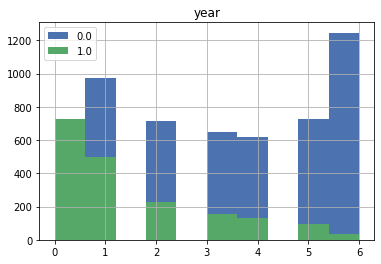

In [32]:
col =['gender', 'Partner','Type', 'PaperlessBilling', 'SeniorCitizen', 'Dependents', 
      'InternetService', 'OnlineSecurity', 'OnlineBackup',
      'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'MultipleLines', 'year']

for i in col:
    data.groupby('client_class')[i].hist()
    plt.legend(data['client_class'].unique())
    plt.title(i)
    plt.show()

In [33]:
data_filter = (
    data
    .pivot_table(index='client_class', values='year', aggfunc='count') # сводная таблица по платформам и суммарным продажам
    .sort_values(by='client_class', ascending=False) # отсортировали по возрастанию
)
data_filter.head()


,year
client_class,
1.0,1869
0.0,5163


Клиенты расторгли договор независимо от пола, 'StreamingTV', 'StreamingMovies', 'MultipleLines', 
На решение влияет наличие услуг 'TechSupport', 'DeviceProtection', 'OnlineBackup', 'OnlineSecurity', 'InternetService'
зависит от наличия иждевенцев и пенсионного статуса, способа выставления счета.
Чаще расторгают договор клиенты с помесячной оплатой, чем на годовой подписке и в первый год пользования услугами.

## Обучение моделей

### CatBoostClassifier

CatBoost позволяет использовать категориальные признаки без необходимости их предварительно обрабатывать. Достаточно задать категориальные признаки с помощью параметра cat_features. 

CatBoostClassifier без проверки на мультиколлинеарность

In [34]:
# разделили данные на обучающую и тестовую выборки
data_train, data_test = train_test_split(
    data, test_size=0.25, random_state=190922)
print(data_train.shape)
data_test.shape

(5274, 19)


(1758, 19)

In [35]:
target_train = data_train['client_class']
features_train = data_train.drop(['client_class'], axis=1)
cat_features = ['Type', 'PaperlessBilling', 'PaymentMethod', 'gender', 'SeniorCitizen', 
                'Partner', 'Dependents', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
                'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'MultipleLines', 'year']

`
model = CatBoostClassifier(random_state=190922, class_weights = [0.75, 0.25])
parameters = { 'learning_rate': [0.01, 0.05],
               'depth': [3, 6]
             }
Grid_CBC = GridSearchCV(estimator=model, param_grid = parameters, cv = 5, n_jobs=-1, scoring='roc_auc')
Grid_CBC.fit(features_train, target_train, cat_features=cat_features, verbose=100)
print("\n The best parameters across ALL searched params:\n",Grid_CBC.best_params_)
Grid_CBC.best_score_
`

The best parameters across ALL searched params:
 {'depth': 6, 'learning_rate': 0.05}
0.918081860710475

In [36]:
model_best = CatBoostClassifier(random_state=190922, class_weights = [0.75, 0.25], max_depth=6, learning_rate=0.05)
model_best.fit(features_train, target_train, cat_features=cat_features, verbose=50)

0:	learn: 0.6438521	total: 68.6ms	remaining: 1m 8s
50:	learn: 0.2065867	total: 754ms	remaining: 14s
100:	learn: 0.1887249	total: 1.44s	remaining: 12.8s
150:	learn: 0.1783825	total: 2.17s	remaining: 12.2s
200:	learn: 0.1674885	total: 2.92s	remaining: 11.6s
250:	learn: 0.1568288	total: 3.69s	remaining: 11s
300:	learn: 0.1497050	total: 4.51s	remaining: 10.5s
350:	learn: 0.1438054	total: 5.34s	remaining: 9.88s
400:	learn: 0.1393084	total: 6.18s	remaining: 9.23s
450:	learn: 0.1358126	total: 6.99s	remaining: 8.51s
500:	learn: 0.1331740	total: 7.84s	remaining: 7.81s
550:	learn: 0.1303009	total: 8.74s	remaining: 7.12s
600:	learn: 0.1280365	total: 9.54s	remaining: 6.33s
650:	learn: 0.1255028	total: 10.4s	remaining: 5.55s
700:	learn: 0.1229452	total: 11.1s	remaining: 4.75s
750:	learn: 0.1205800	total: 12s	remaining: 3.98s
800:	learn: 0.1184127	total: 12.8s	remaining: 3.18s
850:	learn: 0.1157045	total: 13.7s	remaining: 2.39s
900:	learn: 0.1132096	total: 14.5s	remaining: 1.6s
950:	learn: 0.1109285

CatBoostClassifier после проверки на мультиколлинеарность

In [37]:
data_f.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Type              7032 non-null   object 
 1   PaperlessBilling  7032 non-null   object 
 2   PaymentMethod     7032 non-null   object 
 3   MonthlyCharges    7032 non-null   float64
 4   gender            7032 non-null   object 
 5   SeniorCitizen     7032 non-null   int64  
 6   Partner           7032 non-null   object 
 7   Dependents        7032 non-null   object 
 8   MultipleLines     7032 non-null   object 
 9   client_class      7032 non-null   float64
 10  year              7032 non-null   int64  
dtypes: float64(2), int64(2), object(7)
memory usage: 659.2+ KB


In [38]:
cat_features_f = ['Type', 'PaperlessBilling', 'PaymentMethod', 'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'year', 'MultipleLines']

In [39]:
data_train_f, data_test_f = train_test_split(
    data_f, test_size=0.25, random_state=190922)
print(data_train.shape)

data_test.shape

(5274, 19)


(1758, 19)

In [40]:
target_train_f = data_train_f['client_class']
features_train_f = data_train_f.drop(['client_class'], axis=1)

`
model_cat = CatBoostClassifier(random_state=190922, class_weights = [0.75, 0.25])
parameters = { 'learning_rate': [0.01, 0.05],
               'depth': range(2, 7),
               'iterations': range (700, 1000, 100)
             }
Grid_CBC = GridSearchCV(estimator=model_cat, param_grid = parameters, cv = 5, n_jobs=-1, scoring='roc_auc')
Grid_CBC.fit(features_train_f, target_train_f, cat_features=cat_features_f, verbose=100)
print("\n The best parameters across ALL searched params:\n",Grid_CBC.best_params_)
Grid_CBC.best_score_
`

 The best parameters across ALL searched params:
 {'depth': 2, 'iterations': 700, 'learning_rate': 0.05}
0.8745864175605839

In [41]:
%%time

model_cat_best = CatBoostClassifier(random_state=190922, class_weights = [0.75, 0.25], max_depth=2, learning_rate=0.05, iterations=700)
model_cat_best.fit(features_train_f, target_train_f, cat_features=cat_features_f, verbose=50)

0:	learn: 0.6488804	total: 5.07ms	remaining: 3.54s
50:	learn: 0.2468150	total: 181ms	remaining: 2.3s
100:	learn: 0.2337059	total: 347ms	remaining: 2.06s
150:	learn: 0.2305571	total: 528ms	remaining: 1.92s
200:	learn: 0.2287742	total: 744ms	remaining: 1.85s
250:	learn: 0.2276439	total: 940ms	remaining: 1.68s
300:	learn: 0.2268325	total: 1.12s	remaining: 1.49s
350:	learn: 0.2260584	total: 1.3s	remaining: 1.29s
400:	learn: 0.2252236	total: 1.48s	remaining: 1.11s
450:	learn: 0.2245699	total: 1.67s	remaining: 923ms
500:	learn: 0.2239262	total: 1.85s	remaining: 736ms
550:	learn: 0.2234220	total: 2.03s	remaining: 549ms
600:	learn: 0.2229562	total: 2.23s	remaining: 367ms
650:	learn: 0.2226711	total: 2.41s	remaining: 182ms
699:	learn: 0.2222488	total: 2.58s	remaining: 0us
CPU times: user 2.6 s, sys: 111 ms, total: 2.71 s
Wall time: 3.36 s


### LightGBM

In [42]:
target_test_f = data_test_f['client_class']
features_test_f = data_test_f.drop(['client_class'], axis=1)


In [43]:
for col in cat_features_f:
   features_train_f[col] = features_train_f[col].astype('category').copy()
   features_test_f[col] = features_test_f[col].astype('category').copy()
print(features_train_f.info())
features_test_f.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5274 entries, 0014-BMAQU to 6080-TCMYC
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   Type              5274 non-null   category
 1   PaperlessBilling  5274 non-null   category
 2   PaymentMethod     5274 non-null   category
 3   MonthlyCharges    5274 non-null   float64 
 4   gender            5274 non-null   category
 5   SeniorCitizen     5274 non-null   category
 6   Partner           5274 non-null   category
 7   Dependents        5274 non-null   category
 8   MultipleLines     5274 non-null   category
 9   year              5274 non-null   category
dtypes: category(9), float64(1)
memory usage: 130.2+ KB
None
<class 'pandas.core.frame.DataFrame'>
Index: 1758 entries, 4430-YHXGG to 9715-WZCLW
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   Type              1758 non-n

In [44]:
features_cat= list(features_train_f.columns)
print(features_cat)
cat=[]
for i in features_cat:
    if i in cat_features:
        cat.append(features_cat.index(i))
cat        

['Type', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'MultipleLines', 'year']


[0, 1, 2, 4, 5, 6, 7, 8, 9]

`
model_lgb = LGBMClassifier()

parameters = {'class_weight': [None, 'balanced'], 
              'max_depth': [3, 5, 6],
              'learning_rate': [0.05, 0.1],
             }
gsearch = GridSearchCV(model_lgb, param_grid=parameters, cv=5, scoring='roc_auc')
gsearch.fit(features_train_f, target_train_f, verbose=100)
`

print(" Results from Grid Search " )
print("\n The best estimator across ALL searched params:\n")
print("\n The best score across ALL searched params:\n",gsearch.best_score_)
print("\n The best parameters across ALL searched params:\n",gsearch.best_params_)
print("Best score: %0.3f" % gsearch.best_score_)
print("Best parameters set:")
best_parameters = gsearch.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))
`
 

Best score: 0.872
Best parameters set:
	class_weight: None
	learning_rate: 0.05
	max_depth: 3

In [45]:
model_lgb = LGBMClassifier(learning_rate=0.05, max_depth=3, random_state=190922)
model_lgb.fit(features_train_f, target_train_f)

LGBMClassifier(learning_rate=0.05, max_depth=3, random_state=190922)

## Тестирование модели

In [46]:
target_test = data_test['client_class']
features_test = data_test.drop(['client_class'], axis=1)

In [47]:
probabilities_test = model_best.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]

auc_roc = roc_auc_score(target_test, probabilities_one_test)
auc_roc

0.9106086979630345

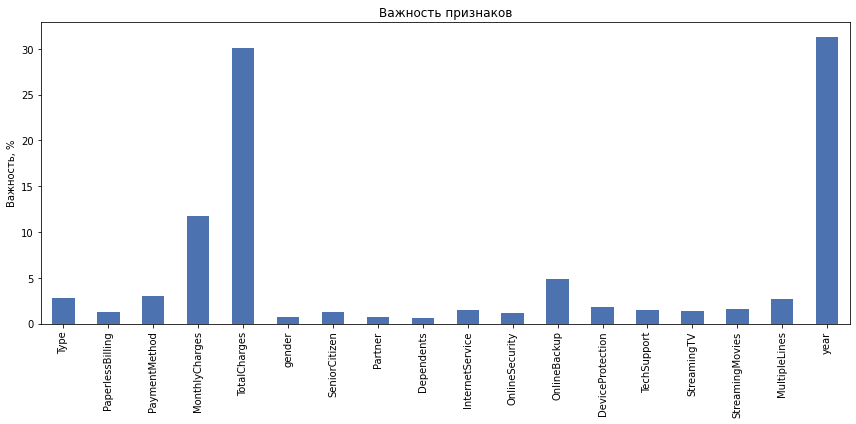

In [48]:
cat_imp = pd.Series(model_best.get_feature_importance(), features_train.columns)
fig, ax = plt.subplots(figsize=(12, 6))
cat_imp.plot.bar(ax=ax)
ax.set_title("Важность признаков")
ax.set_ylabel('Важность, %')
fig.tight_layout()

## Вывод

 Для того, чтобы построить прототип модели машинного обучения для оператора связи «Ниединогоразрыва.ком», которая должна предсказать, планирует ли пользователь уйти необходимо решить задачу бинарной классификации.  
  Для решения этой задачи были проделаны следующие операции.
 -  Подготовка и предобработка данных.
 
 На этом этапе загрузили и изучили предоставленные  данные:
* contract.csv — информация о договоре;
* personal.csv — персональные данные клиента;
* internet.csv — информация об интернет-услугах;
* phone.csv — информация об услугах телефонии.
 Проверили данные на пропуски, дубликаты. Заполнить пропущенные значения, объединили таблицы. Создали новые признаки и сгруппировали по категориям

- Провели исследовательский анализ данных:

Изучили как распределены данные, проверили на мультиколлинеарность, определили обучающие признаки, сформировали целевой признак. Обучающую выборку проверили на баланс классов.

- Обучение моделей:

Построили и обучили модели CatBoostClasifier и LightGBMClasifier, эти модели меньше подвержены влиянию мульколлинеарности и работаютс категориальными признаками, которые преобладают в данной задаче. Подобрали оптимальные гиперпараметры GridSearchCV, оценивая модели метрикой AUC-ROC. Обучили модель CatBoostClasifier на обучающей выборке без учета мультиколлинеарности и удалив коррелирующие признаки. Лучшее значение метрики AUC-ROC = 0.918
 получили на модели
 - CatBoostClassifier(random_state=190922, class_weights = [0.75, 0.25], max_depth=6, learning_rate=0.05)



Провели финальное тестирование и проверили на важность признаков. AUC-ROC = 0.911 на финальном тестировании. Модель как наиболее важные признаки отбирает срок действия договора и общие суммы платежей.

